In [1]:

import rioxarray as rxr
import matplotlib.pyplot as plt
from working_sca_funcs import create_binary_chm, extract_dates, closest_date, calc_rgb
import geopandas as gpd
import numpy as np
from scipy.signal import convolve2d
import glob
import os
import pandas as pd
import xarray as xr
from datetime import datetime
import rasterio as rio
import netCDF4
import cmcrameri.cm as cmc
import matplotlib.patches as patches
from working_sca_funcs import create_binary_chm, extract_dates, closest_date, calc_rgb, create_validation_dataset, calculate_metrics

In [1]:
# from working_sca_funcs import validation_tif_binary
# year = '2022'
# name = 'BUDD'
# aso_dir = f'/home/etboud/projects/data/aso/'
# aso_tif = glob.glob(aso_dir + f'*{year}*3m*.tif')
# validation_tif_binary(aso_tif, basin, year, name)

In [2]:
name = 'BUDD'
year = 2022
model = 'V5'
#set the post processed snow map directory with .nc files for entire season
#pp_fn= '/home/etboud/projects/snow_mapping/Emma/BUDD_rec_V9PP_2022_10_10_NDVI_QAQC_2.nc'
pp_fn = f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V9PP_{year}_10_10_NDVI_QAQC_2.nc'
# set the original snow map directory with individual .tif files
data_direc = f'/home/etboud/projects/data/temp/{name}/V9/'
data_direc = f'/data0/images/planet/emma/planet/rerun/{name}/{model}/'


In [13]:
rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
rgi_mask = gpd.read_file(rgi).to_crs('EPSG:32611')
wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
wbd_mask = gpd.read_file(wbd).to_crs('EPSG:32611')
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
#basin = gpd.read_file('/home/etboud/projects/snow_mapping/Emma/budd_rectangle_modis_extent_32611.geojson')
basin = gpd.read_file(BS)
basin = basin.to_crs('EPSG:32611') 

### give planet data projection

In [14]:

# Set parameters
starting_value = 0

# Open the NetCDF file
pp = xr.open_dataset(pp_fn)
# List the raster files
files = sorted(glob.glob(data_direc + '*SCA.tif'))[starting_value:]
print(files)

# Open the first raster file using rioxarray
temp = rxr.open_rasterio(files[0]).isel(band=0)

# Ensure that the CRS of the basin shapefile and the raster are the same
basin = basin.to_crs(temp.rio.crs)

# Clip the raster data to the basin's geometry
temp_clipped = temp.rio.clip(basin.geometry.values, basin.crs)

['/data0/images/planet/emma/planet/rerun/BUDD/V5/20200326_163306_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200401_163321_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200407_163510_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200411_163122_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200413_163141_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200413_184937_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200421_163154_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200422_163230_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200428_183213_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200429_162845_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200506_183733_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200511_181045_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200515_182612_SCA.tif', '/data0/images/planet/emma/planet/rer

In [15]:

def project_raster_to_utm(nc_fn, data_direc, basin):
    """
    Projects the raster data to UTM coordinates.
    """
    # Set parameters
    starting_value = 0

    # Open the NetCDF file
    
    nc = xr.open_dataset(nc_fn)
    # List the raster files
    files = sorted(glob.glob(data_direc + '*SCA.tif'))[starting_value:]
    print(files)

    # Open the first raster file using rioxarray
    temp = rxr.open_rasterio(files[0]).isel(band=0)

    # Ensure that the CRS of the basin shapefile and the raster are the same
    basin = basin.to_crs(temp.rio.crs)

    # Clip the raster data to the basin's geometry
    temp_clipped = temp.rio.clip(basin.geometry.values, basin.crs)
    # Initialize a list to hold the processed DataArrays for each time step
    processed_data_list = []

    # Loop over each time step in the NetCDF dataset
    for t in nc.time.values:
        # Select the time slice from the NetCDF dataset
        time_data = nc.sel(time=t).to_array().values  # Shape: (1, 1313, 1050)
        
        # Debug: Check the shape of the selected time slice
        print(f"Shape of time slice {t}: {time_data.shape}")
        
        # Slice the time data to match the clipped raster size (temp_clipped)
        time_data_sliced = time_data[0, :temp_clipped.sizes['y'], :temp_clipped.sizes['x']]  # Remove the band dimension
            # Expand the dimensions to add the 'time' dimension
        time_data_expanded = np.expand_dims(time_data_sliced, axis=0)  # Shape becomes (1, 1313, 1050)
        print(f"Shape of time slice {t}: {time_data_expanded.shape}")
        if len(time_data_expanded.shape) >3:
            time_data_expanded = time_data_expanded[0:1, 0, :, :]
            if time_data_expanded.shape[0] != temp_clipped.shape[0]:
                #skip
                print(f"Skipping time slice {t} due to shape mismatch.")
                continue
        else:
            pass

        # Create a DataArray for the current time step with proper coordinates
        data_array = xr.DataArray(
            time_data_expanded,  # Now matches the clipped raster size
            dims=('time', 'y', 'x'),
            coords={'time': [t], 'y': temp_clipped.y, 'x': temp_clipped.x}
        )
        
        # Add the processed time step to the list
        processed_data_list.append(data_array)

    # Stack the processed data along the time dimension
    stacked_data = np.concatenate([da.values for da in processed_data_list], axis=0)  # Ensure correct stacking
    processed_dataset = xr.Dataset(
        {
            'band_data': (['time', 'y', 'x'], stacked_data),
        },
        coords={
            'time': [da.time.values[0] for da in processed_data_list],  # Extract time values from processed data
            'y': temp_clipped.y,
            'x': temp_clipped.x
        })

    return processed_dataset



In [16]:
#V3PP = project_raster_to_utm('/data0/images/planet/emma/planet/rerun/BUDD/PP/BUDD_V9PP_2022_10_10_NDVI_QAQC_2.nc', '/data0/images/planet/emma/planet/rerun/BUDD/V9/', basin)
V2PP = project_raster_to_utm('/data0/images/planet/emma/planet/rerun/BUDD/PP/BUDD_V5PP_2022_3_50_NDVI_QAQC_3.nc', '/data0/images/planet/emma/planet/rerun/BUDD/V5/', basin)
V2 = project_raster_to_utm('/data0/images/planet/emma/planet/rerun/BUDD/PP/BUDD_V5_2022_model_output.nc', '/data0/images/planet/emma/planet/rerun/BUDD/V5/', basin)

['/data0/images/planet/emma/planet/rerun/BUDD/V5/20200326_163306_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200401_163321_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200407_163510_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200411_163122_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200413_163141_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200413_184937_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200421_163154_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200422_163230_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200428_183213_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200429_162845_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200506_183733_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200511_181045_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20200515_182612_SCA.tif', '/data0/images/planet/emma/planet/rer

Shape of time slice 2022-06-10T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-06-10T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-06-19T00:00:00.000000000: (1, 3, 1627, 914)
Shape of time slice 2022-06-19T00:00:00.000000000: (1, 3, 914, 914)
Skipping time slice 2022-06-19T00:00:00.000000000 due to shape mismatch.
Shape of time slice 2022-06-19T00:00:00.000000000: (1, 3, 1627, 914)
Shape of time slice 2022-06-19T00:00:00.000000000: (1, 3, 914, 914)
Skipping time slice 2022-06-19T00:00:00.000000000 due to shape mismatch.
Shape of time slice 2022-06-19T00:00:00.000000000: (1, 3, 1627, 914)
Shape of time slice 2022-06-19T00:00:00.000000000: (1, 3, 914, 914)
Skipping time slice 2022-06-19T00:00:00.000000000 due to shape mismatch.
Shape of time slice 2022-06-21T00:00:00.000000000: (1, 2, 1627, 914)
Shape of time slice 2022-06-21T00:00:00.000000000: (1, 2, 914, 914)
Skipping time slice 2022-06-21T00:00:00.000000000 due to shape mismatch.
Shape of time slice 2022-06-

In [ ]:

fig, ax = plt.subplots()
V2PP['band_data'].sel(time='2022-06-10').plot(ax=ax)

In [ ]:
def read_modis_albedo_snowtoday(wy, modis_dir, start_date, end_date):
    
    files = glob.glob(modis_dir + f'*{wy}*nc')
    print(files)
    # select modis file between start and end dates
    dates = [i.split('/')[-1].split('_')[-2] for i in files]
    print(dates)
    files = [files[i] for i, date_str in enumerate(dates)
            if start_date <= pd.to_datetime(date_str) <= end_date]
    files.sort()
    ds_list = []
    print(files)
    sca_list = []
    for f in files[0:]:
        ds = xr.open_dataset(f,engine='netcdf4')
        # albedo_s - no adjustment
        # modis_albedo_s = ds['albedo_clean_flat']  # adjusted to account for slope and aspect of the terrain
        modis_sca = ds['snow_fraction']

        date_str = f.split('/')[-1].split('_')[-2]
        date = pd.to_datetime(date_str)
        # modis_albedo_s = modis_albedo_s.expand_dims('time')
        # modis_albedo_s = modis_albedo_s.assign_coords(ds.coords)
        # modis_albedo_s = modis_albedo_s.assign_coords(time=('time', [date]))
        modis_sca = modis_sca.assign_coords(ds.coords)
        modis_sca = modis_sca.assign_coords(time=('time', [date]))

        #ds_list.append(modis_albedo_s)
        sca_list.append(modis_sca)

    proj4_str = ds.crs.proj4
    # combine_ds_albedo = xr.concat(ds_list, dim='time')
    
    # combine_ds_albedo.rio.write_crs(proj4_str, inplace=True)
    combine_ds_sca = xr.concat(sca_list, dim='time')
    combine_ds_sca.rio.write_crs(proj4_str, inplace=True)
    return combine_ds_sca #combine_ds_albedo,


In [18]:
wateryear = 2022
modis_dir = '/data0/images/STC_MODSCG/h08v05/'
#modis_dir = '/home/etboud/projects/data/temp/MODSCAG/'
start_date = pd.to_datetime(f'{wateryear}-04-01')
end_date = pd.to_datetime(f'{wateryear+1}-09-30')
model_ir = V2PP

In [19]:

modis_sca_ds = read_modis_albedo_snowtoday(
    wy=wateryear,
    modis_dir=modis_dir,
    start_date=start_date,
    end_date=end_date
) # modis_albedo_ds,

# reproject match modis to model domain and resolution -- maybe too large
repo_modis_sca = modis_sca_ds.rio.reproject_match(model_ir)
#repo_modis_albedo = modis_albedo_ds.rio.reproject_match(model_ir)

['/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220102_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220919_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220809_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220210_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220810_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220129_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220902_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220629_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220509_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220331_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220308_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST_h08v05_20220303_v01.0.nc', '/data0/images/STC_MODSCG/h08v05/STC_MODSCGDRF_HIST

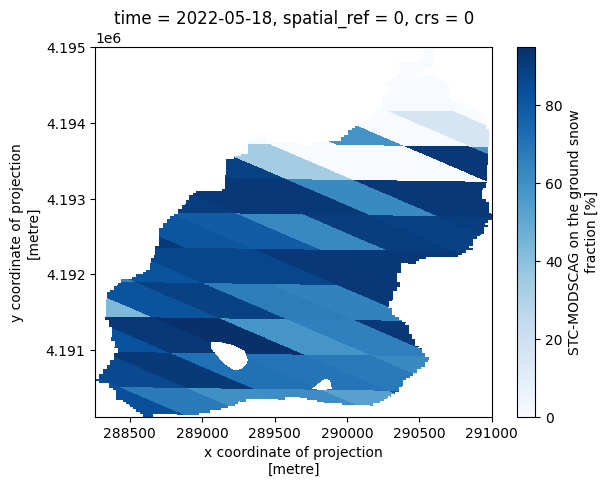

In [12]:
# Ensure CRS of basin matches repo_modis_sca
basin = basin.to_crs(repo_modis_sca.rio.crs)
rgi_mask = gpd.read_file(rgi).to_crs(repo_modis_sca.rio.crs)
wbd_mask = gpd.read_file(wbd).to_crs(repo_modis_sca.rio.crs)
# Clip and plot
fig, ax = plt.subplots()
clipped_data = repo_modis_sca.sel(time='2022-05-18').rio.clip(basin.geometry.values, basin.crs).rio.clip(rgi_mask.geometry.values, rgi_mask.crs, invert = True).rio.clip(wbd_mask.geometry.values, wbd_mask.crs, invert= True)
clipped_data.plot(ax=ax, cmap='Blues')

In [16]:
# save clipped_data as tif
clipped_data.rio.to_raster('/home/etboud/projects/data/temp/modis_sca_2022_05_18.tif')

In [20]:
fsca_list = []
for i in range(len(repo_modis_sca.time)):
    clipped_data = repo_modis_sca.isel(time=i).rio.clip(basin.geometry.values, basin.crs).rio.clip(rgi_mask.geometry.values, rgi_mask.crs, invert = True).rio.clip(wbd_mask.geometry.values, wbd_mask.crs, invert= True)
    fsca = np.nansum(clipped_data) / np.count_nonzero(~np.isnan(clipped_data))
    fsca_list.append(fsca)

In [21]:
#create dataframe with fsca_list and corresponding dates
dates = pd.to_datetime(repo_modis_sca.time.values)
modis_fsca_df = pd.DataFrame({'date': dates, 'fsca': fsca_list})

In [15]:
model = 'V5'
pp = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_{model}PP_2022_3_50_NDVI_QAQC_3.nc')
pp
ps_fsca_list = []
dates = pd.to_datetime(pp.time.values)  # Move this outside the loop
for i in range(len(pp.time)):
    clipped_data = pp.isel(time=i)
    fsca = np.nansum(clipped_data.to_array()) / np.count_nonzero(~np.isnan(clipped_data.to_array()))
    fsca = fsca * 100
    ps_fsca_list.append(fsca)

ps_fsca_df = pd.DataFrame({'date': dates, 'fsca': ps_fsca_list})  # Create the DataFrame after the loop

In [16]:
ps_fsca_df

,date,fsca
0,2022-03-30,95.880933
1,2022-04-01,93.461791
2,2022-04-03,93.003824
3,2022-04-07,90.961084
4,2022-04-10,90.462453
...,...,...
77,2022-09-24,0.188561
78,2022-09-24,0.194678
79,2022-09-25,0.127386
80,2022-09-28,0.097039


In [17]:
modis_fsca_df

,date,fsca
0,2022-04-01,86.116658
1,2022-04-02,86.982809
2,2022-04-03,87.065737
3,2022-04-04,86.750366
4,2022-04-05,85.294956
...,...,...
178,2022-09-26,0.000000
179,2022-09-27,0.000000
180,2022-09-28,0.000000
181,2022-09-29,0.000000


In [18]:
ps_fsca_df

,date,fsca
0,2022-03-30,95.880933
1,2022-04-01,93.461791
2,2022-04-03,93.003824
3,2022-04-07,90.961084
4,2022-04-10,90.462453
...,...,...
77,2022-09-24,0.188561
78,2022-09-24,0.194678
79,2022-09-25,0.127386
80,2022-09-28,0.097039


In [ ]:
# merge modis oon ps dates
modis_fsca_df['date'] = pd.to_datetime(modis_fsca_df['date'])
ps_fsca_df['date'] = pd.to_datetime(ps_fsca_df['date'])
merged_df = pd.merge(modis_fsca_df, ps_fsca_df, on='date', suffixes=('_modis', '_ps'))
# merged_df['fsca_modis'].value_counts()

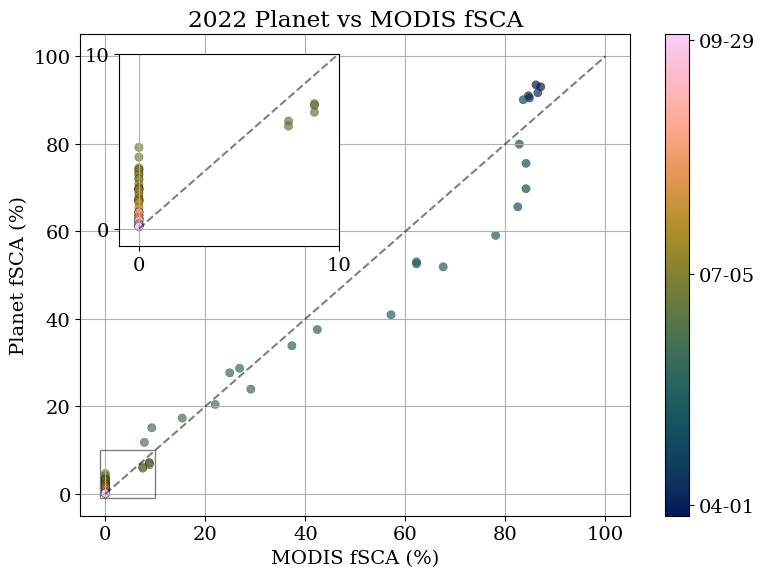

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# If 'date' is not in datetime format, convert it
ps_fsca_df["date"] = pd.to_datetime(ps_fsca_df["date"], errors="coerce")

# Normalize the 'date' to a range [0, 1] for colormap usage (earlier dates -> lower values)
date_norm = (merged_df["date"] - merged_df["date"].min()) / (
    merged_df["date"].max() - merged_df["date"].min()
)

# Generate colors using the `batlow` colormap
colors = cmc.batlow(date_norm)
# Plot
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    merged_df['fsca_modis'],
    merged_df['fsca_ps'],
    c=colors,

    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# add inset zoomed in
axins = ax.inset_axes([0.07, 0.56, 0.4, 0.4])  # [x, y, width, height]
axins.scatter(
    merged_df['fsca_modis'],
    merged_df['fsca_ps'],
    c=colors,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.2
)
# Set limits for the inset
axins.set_xlim(-1, 10)
axins.set_ylim(-1, 10)
axins.set_xticks([0, 10])
axins.set_yticks([0, 10])
# Add grid to the inset
axins.grid(True)
# mark where inset ins on main plot
x1, x2, y1, y2 = 0, 10, 0, 10
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5)
# draw lines on inset
axins.plot([0, 10], [0, 10], color='black', alpha = .5, linestyle='--')
# mark correspiing region on main plot and draw 2 lines linking two axes)

# Add colorbar to show date mapping
sm = cm.ScalarMappable(cmap=cmc.batlow, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Date')
# add 1 to 1 line
x = np.linspace(0, 100, 100)
y = x
ax.plot(x, y, color='black', alpha = .5, linestyle='--', label='1:1 Line')
# Labeling
ax.set_xlabel('STC-MODSCAG Basin fSCA (%)')
ax.set_ylabel('PP Basin fSCA (%)')
ax.set_title('2022 PP PS vs MODIS Basin fSCA')
# ax.set_xlim(0, 100)
# ax.set_ylim(0, 100)
# fix colobar labels to be datetime objects
cbar.set_ticks([738250,738337, 738425])
cbar.set_ticklabels([merged_df['date'].min().strftime('%m-%d'), merged_df['date'].median().strftime('%m-%d'),merged_df['date'].max().strftime('%m-%d')])

ax.grid(True)
plt.tight_layout()
plt.show()


In [22]:
def ps_fsca_df(processed_dataset, basin, rgi_mask, wbd_mask):
    """
    Calculate the percent snow covered area (PSFCA) for each time step in the processed dataset.
    """

    ps_fsca_list = []
    for i in range(len(processed_dataset.time)):
        clipped_data = processed_dataset.isel(time=i).rio.clip(basin.geometry.values, basin.crs).rio.clip(rgi_mask.geometry.values, rgi_mask.crs, invert = True).rio.clip(wbd_mask.geometry.values, wbd_mask.crs, invert= True)
        fsca = np.nansum(clipped_data.to_array()) / np.count_nonzero(~np.isnan(clipped_data.to_array()))
        fsca = fsca*100
        ps_fsca_list.append(fsca)
    dates = pd.to_datetime(processed_dataset.time.values)
    ps_fsca_df = pd.DataFrame({'date': dates, 'fsca': ps_fsca_list})
    return ps_fsca_df 

In [17]:
V2PP = ps_fsca_df(V2PP, basin, rgi_mask, wbd_mask)
#V3PP = ps_fsca_df(V3PP, basin, rgi_mask, wbd_mask)

In [23]:
aso_nc = f'/home/etboud/projects/ps_sca/{name}_aso.nc'
aso = xr.open_dataset(aso_nc)
aso = project_raster_to_utm(aso_nc, '/data0/images/planet/emma/planet/rerun/BUDD/V9/', basin)

['/data0/images/planet/emma/planet/rerun/BUDD/V9/20200326_163306_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200401_163321_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200407_163510_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200411_163122_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200413_163141_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200413_184937_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200421_163154_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200422_163230_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200428_183213_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200429_162845_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200506_183733_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200511_181045_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V9/20200515_182612_SCA.tif', '/data0/images/planet/emma/planet/rer

Shape of time slice 2022-04-29T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-04-29T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-05-18T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-05-18T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2023-04-27T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2023-04-27T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2023-06-01T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2023-06-01T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2023-06-26T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2023-06-26T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-04-05T00:00:00.000000000: (1, 1627, 914)
Shape of time slice 2022-04-05T00:00:00.000000000: (1, 1627, 914)


In [24]:
aso_df = ps_fsca_df(aso, basin, rgi_mask, wbd_mask)

In [ ]:
#aso in 2023 sorted
aso_df= aso_df[aso_df['date'] < '2023-01-01'].sort_values(by='date', ascending=True)

In [ ]:
fig, ax = plt.subplots()
V2PP.plot(x='date', y='fsca', ax=ax, color='cadetblue',linewidth = 3,label = 'V2PP',)
V3PP.plot(x='date', y='fsca', ax=ax, color='darkkhaki',linewidth = 3,label = 'V3PP')
fsca_df.plot(x='date', y='fsca', ax=ax, color='darkorange', linewidth = 3,label='STC-MODSCAG')
aso_df.plot(x='date', y='fsca', ax=ax, color='darkviolet', linewidth = 3,label='ASO')
ax.set_ylabel('Basin Snow Covered Area (%)')
ax.set_xlabel('')
ax.set_title('Budd Basin Snow Covered Area')


In [87]:
kernel_df

,radius,threshold,pixels,area


In [133]:
nc = xr.open_dataset('/home/etboud/projects/snow_mapping/Emma/BUDD_V5_2022_5_20_NDVI_QAQC_2.nc')

In [177]:
files = glob.glob('/data0/images/planet/emma/planet/rerun/BUDD/PP/*BUDD*3_*NDVI_QAQC_3.nc')

In [178]:
ps_fsca_data = []

for file in files:
    nc = xr.open_dataset(file)
    threshold = file.split('/')[-1].split('_')[4]
    radius = file.split('/')[-1].split('_')[3]
    
    for i in range(len(nc.time)):
        clipped_data = nc.isel(time=i)
        fsca = np.nansum(clipped_data.to_array() == 1) / np.count_nonzero(~np.isnan(clipped_data.to_array()))
        fsca = fsca * 100
        date = pd.to_datetime(nc.time[i].values)

        ps_fsca_data.append({
            'date': date,
            'threshold': threshold,
            'radius': radius,
            'fsca': fsca
        })

ps_fsca_data = pd.DataFrame(ps_fsca_data)

In [176]:
ps_fsca_data

,date,threshold,radius,fsca
0,2022-03-30,35,4,96.685675
1,2022-04-01,35,4,94.362132
2,2022-04-03,35,4,93.923717
3,2022-04-07,35,4,92.074335
4,2022-04-10,35,4,91.753110
...,...,...,...,...
979,2022-09-24,50,3,0.188561
980,2022-09-24,50,3,0.194678
981,2022-09-25,50,3,0.127386
982,2022-09-28,50,3,0.097039


In [5]:
year = '2022'
name = 'BUDD'

In [ ]:
pp = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V5PP_{year}_3_50_NDVI_QAQC_3.nc')

pp_fsca_list = []
for i, date in enumerate(pp.time.values):
    p_slice = pp.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    pp_fsca_list.append(fsca)
dates = pd.to_datetime(pp.time.values)
pp_fsca_df = pd.DataFrame({'date': dates, 'fsca': pp_fsca_list})

In [8]:
p9 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V9_{year}_model_output.nc')

p_V9_fsca_list = []
for i, date in enumerate(p9.time.values):
    p_slice = p9.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V9_fsca_list.append(fsca)
dates = pd.to_datetime(p9.time.values)
p_V9_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V9_fsca_list})

In [9]:
p5 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V5_{year}_model_output.nc')

p_V5_fsca_list = []
for i, date in enumerate(p5.time.values):
    p_slice = p5.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V5_fsca_list.append(fsca)
dates = pd.to_datetime(p5.time.values)
p_V5_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V5_fsca_list})

In [10]:
p7 = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_V7_{year}_model_output.nc')

p_V7_fsca_list = []
for i, date in enumerate(p7.time.values):
    p_slice = p7.sel(time=date).to_array().values[0, :, :]
    fsca = np.nansum(p_slice) / np.count_nonzero(~np.isnan(p_slice))
    fsca = fsca*100
    p_V7_fsca_list.append(fsca)
dates = pd.to_datetime(p7.time.values)
p_V7_fsca_df = pd.DataFrame({'date': dates, 'fsca': p_V7_fsca_list})

Text(0.5, 0, 'Date')

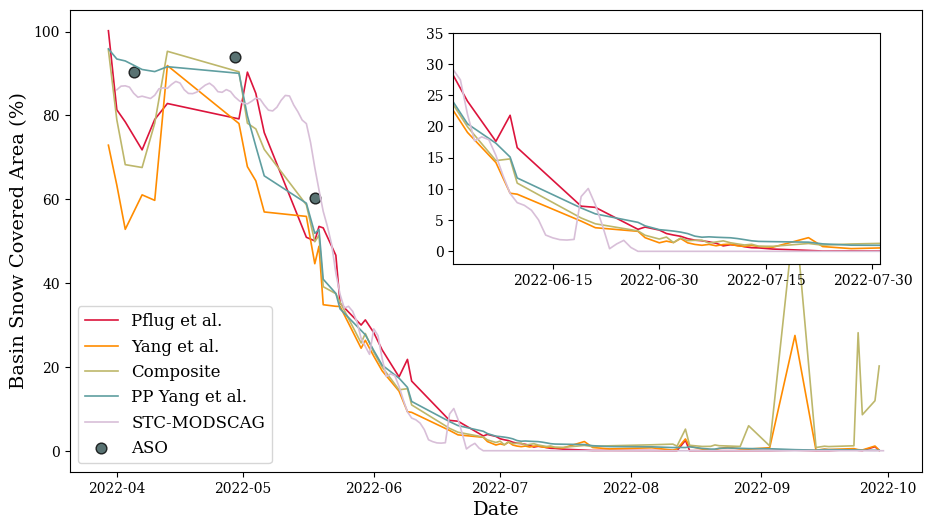

In [60]:
from matplotlib.dates import DateFormatter, DayLocator
import matplotlib.dates as mdates

# plot the timeseries of each combination of threshold and radius
fig, ax = plt.subplots(figsize=(11, 6))
plt.rcParams['font.family'] = 'serif'
#num_lines = len(ps_fsca_data['threshold'].unique())  # however many lines you need to plot
# Get evenly spaced colors from the batlow colormap
# colors = cmc.batlow(np.linspace(0, 1, num_lines))
# i = 0  # Initialize color index
# for radius in ps_fsca_data['radius'].unique():
#     for threshold in np.sort(ps_fsca_data['threshold'].unique()):
#         subset = ps_fsca_data[(ps_fsca_data['radius'] == radius) & (ps_fsca_data['threshold'] == threshold)]
#         ax.plot(subset['date'], subset['fsca'], color=colors[i], label=f'Radius: {radius}, Threshold: {threshold}')
#         i += 1  # Increment color index
# Add an inset zoomed in on the range from 2022-06 to 2022-07

axins = ax.inset_axes([0.45, 0.45, 0.5, 0.5])  # [x, y, width, height]
for df, label, color in zip(
    [p_V7_fsca_df, p_V5_fsca_df, p_V9_fsca_df, pp_fsca_df, modis_fsca_df, aso_df],
    ['Pflug et al.', 'Yang et al.', 'Composite', 'PP Yang et al.', 'STC-MODSCAG'],
    ['crimson', 'darkorange', 'darkkhaki', 'cadetblue', 'thistle']
):
    axins.plot(df['date'], df['fsca'], label=label, color=color, linewidth=1.2)

# Set limits for the inset
axins.set_xlim(pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31'))
axins.set_ylim(-2, 35)

# Format the x-axis of the inset
#axins.xaxis.set_major_formatter(DateFormatter('%b-%d'))
# only show every 2nd date
axins.xaxis.set_major_locator(mdates.DayLocator(interval=15))

# Add grid and labels to the inset
axins.grid(False)
#axins.set_title('Zoom: Jun-Jul 2022', fontsize=10)
# mark wher eon major axis the zoomed in box is
# x1, x2, y1, y2 = pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31'), -2, 35
# ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.2)


# x1, x2 = pd.to_datetime('2022-06-01'), pd.to_datetime('2022-07-31')
# y1, y2 = -2, 35
# from matplotlib.patches import Rectangle
# # Draw rectangle manually on main axes (zoom area)
# rect = Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='black', facecolor='none', alpha=0.5, lw=.5)
# ax.add_patch(rect)


ax.plot(p_V7_fsca_df['date'], p_V7_fsca_df['fsca'], label='Pflug et al.', color='crimson', linewidth=1.2)
ax.plot(p_V5_fsca_df['date'], p_V5_fsca_df['fsca'], label='Yang et al.', color='darkorange', linewidth=1.2)
ax.plot(p_V9_fsca_df['date'], p_V9_fsca_df['fsca'], label='Composite', color='darkkhaki', linewidth=1.2)
ax.plot(pp_fsca_df['date'], pp_fsca_df['fsca'], label='PP Yang et al.', color='cadetblue', linewidth=1.2)        
ax.plot(modis_fsca_df['date'], modis_fsca_df['fsca'], label='STC-MODSCAG', color='thistle', linewidth=1.2)
ax.scatter(aso_df['date'], aso_df['fsca'], label='ASO',marker = 'o', alpha = .8, c='darkslategrey', s=60, edgecolors='black')
#ax.plot(aso_df['date'], aso_df['fsca'], label='ASO',c='darkslategrey')
ax.legend(loc='lower left', fontsize=12)
ax.set_ylabel('Basin Snow Covered Area (%)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)



In [73]:
V2PP = project_raster_to_utm(files[0], '/data0/images/planet/emma/planet/rerun/BUDD/V5/', basin)

['/data0/images/planet/emma/planet/rerun/BUDD/V5/20220330_175450_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220401_182254_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220403_174654_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220407_174501_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220410_182041_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220413_182322_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220430_181902_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220502_175034_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220504_174505_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220504_183833_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220506_182131_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220516_174738_SCA.tif', '/data0/images/planet/emma/planet/rerun/BUDD/V5/20220518_182210_SCA.tif', '/data0/images/planet/emma/planet/rer

In [ ]:



# Loop through each time step and plot the corresponding data
for i, date in enumerate(V2PP.time.values):
    # Create a single figure to hold all subplots (for each time step)
    fig, ax = plt.subplots( figsize=(11, 6))
    ax = np.ravel(ax)
    # Plot each time step on a different subplot
    ax[0].imshow(V2PP.isel(time=i)['band_data'], cmap='Blues', vmin=0, vmax=1)
    ax[0].set_title(f"Date: {str(date)}")  # Optionally, set the title for each subplot
    ax[0].axis('off')  # Turn off axis labels if not needed

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

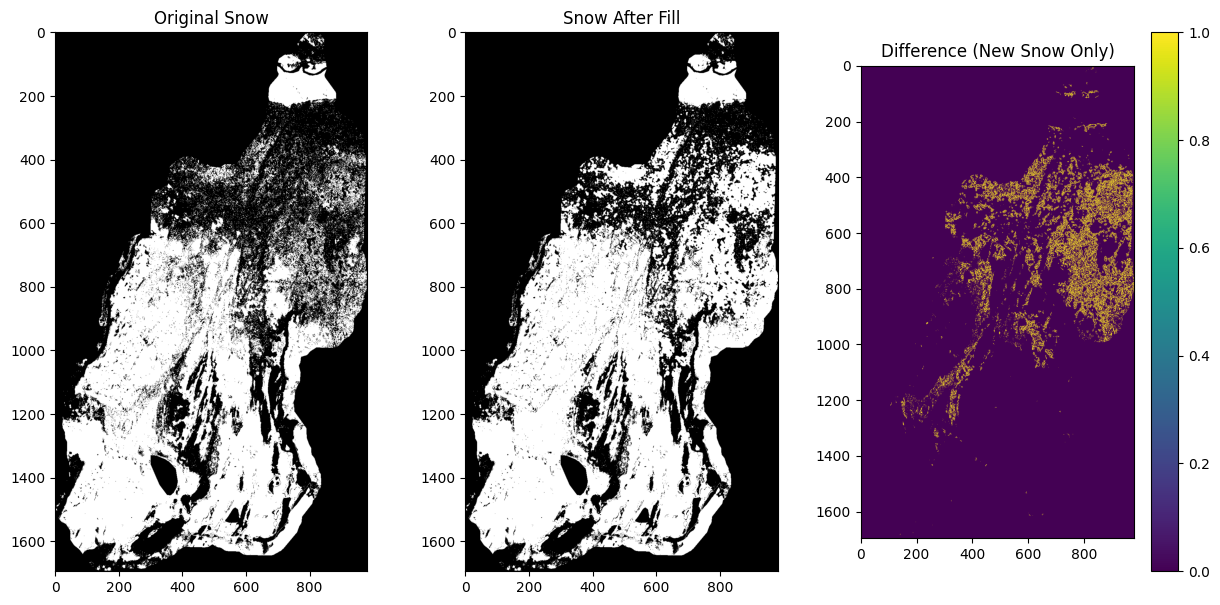

In [ ]:
# basin_buff = gpd.read_file('/home/etboud/projects/data/basins/BUDD/BUDD_BS_4326.geojson').to_crs('EPSG:32611')
# mask = f'/home/etboud/projects/data/masks/4b_15img_ndvi_45_85_{name}_notclipped.tif'
# # basin_mask = '/home/etboud/projects/snow_mapping/Emma/BUDD_rec_mask_buffered.tif'
# mask = rxr.open_rasterio(mask)
# mask.values = np.where(mask.values>0, 0, np.nan)

# data = rxr.open_rasterio('/data0/images/planet/emma/planet/rerun/BUDD/V5/20220407_174501_SCA.tif', drop=True, masked=True).rio.reproject(basin.crs)
# #data.values = np.where(np.isnan(data.values), 0, data.values)
# clipped_data = data.rio.clip(basin_buff.geometry.values, basin_buff.crs,drop=True)
# clipped_data = data.rio.clip(rgi_mask.geometry, invert=True) #testing
# clipped_data = clipped_data.rio.clip(wbd_mask.geometry,invert=True) #testing
# clipped_data.squeeze()

# # Ensure the mask is boolean: valid_mask is True where canopy is present (mask == 0)
# valid_mask = (mask == 0)

# # Perform convolution on the entire image
# convolved = convolve2d(clipped_data.squeeze().values, kernel, mode='same', boundary='symm')

# # Calculate the number of elements in the kernel
# kernel_size = kernel.size

# # Calculate the threshold based on the percentage of the kernel size
# threshold = .1 * kernel_size

# # Create a new binary image based on the neighbor count
# adjusted_snow_image = np.where(convolved >= threshold, 1, 0)

# # Create an output image initialized with original image
# convolved_stack = np.copy(clipped_data.squeeze().values)

# # Only keep the adjusted snow values where the mask is valid
# # Ensure valid_mask and adjusted_snow_image have the same shape
# valid_mask = valid_mask.squeeze().values
# adjusted_snow_image = adjusted_snow_image.squeeze()
# update_mask = (convolved_stack == 0)& valid_mask & (adjusted_snow_image==1)
# # Update the convolved_stack only where the mask is valid and convolved_stack is 0
# convolved_stack[(update_mask)]=1# Make sure your clipped_data is binary (1 for snow, 0 for no snow)
# snow_binary = np.where(clipped_data.squeeze().values > 0, 1, 0)

# # Convolve the binary snow map
# convolved = convolve2d(snow_binary, kernel, mode='same', boundary='symm')

# # Decide how much snow in the neighborhood is enough to suggest snow
# threshold = 0.2 * np.sum(kernel==1)  # Try 0.1 or 0.3 as needed

# # Suggest snow where there is currently no snow and the neighborhood supports it
# adjusted_snow_image = np.where(convolved >= threshold, 1, 0)

# # Create output initialized with original snow
# convolved_stack = np.copy(snow_binary)

# # Apply the adjusted snow values only to:
# #  - pixels that are currently 0
# #  - under the canopy (valid_mask == True)
# #  - where convolution suggests snow (adjusted_snow_image == 1)
# update_mask = (snow_binary == 0) & valid_mask & (adjusted_snow_image == 1)
# convolved_stack[update_mask] = 1  # Fill in these pixels with snow# 1. Check kernel
# print("Kernel:\n", kernel)

# # 2. Check input image stats
# input_image = clipped_data.squeeze().values
# print("Input image stats:", np.nanmin(input_image), np.nanmax(input_image), np.unique(input_image))

# # 3. Check convolution result
# print("Convolved stats:", np.nanmin(convolved), np.nanmax(convolved))
# print("Adjusted snow image unique values:", np.unique(adjusted_snow_image))

# # 4. Plot intermediate results (if possible)
# import matplotlib.pyplot as plt

# plt.subplot(1, 3, 1)
# plt.imshow(input_image, cmap='gray')
# plt.title('Input Image')

# plt.subplot(1, 3, 2)
# plt.imshow(convolved, cmap='hot')
# plt.title('Convolved')

# plt.subplot(1, 3, 3)
# plt.imshow(adjusted_snow_image, cmap='binary')
# plt.title('Adjusted Snow Image')

# plt.show()
# print("Original snow pixel count:", np.sum(snow_binary))
# print("New snow pixel count:", np.sum(convolved_stack))
# print("Pixels added:", np.sum(convolved_stack) - np.sum(snow_binary))
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 7))
# plt.subplot(1, 3, 1)
# plt.imshow(snow_binary, cmap='gray')
# plt.title('Original Snow')

# plt.subplot(1, 3, 2)
# plt.imshow(convolved_stack, cmap='gray')
# plt.title('Snow After Fill')

# plt.subplot(1, 3, 3)
# plt.imshow(convolved_stack - snow_binary, cmap='viridis')
# plt.colorbar()
# plt.title('Difference (New Snow Only)')

# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019184377..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019184377..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019184377..1.0].


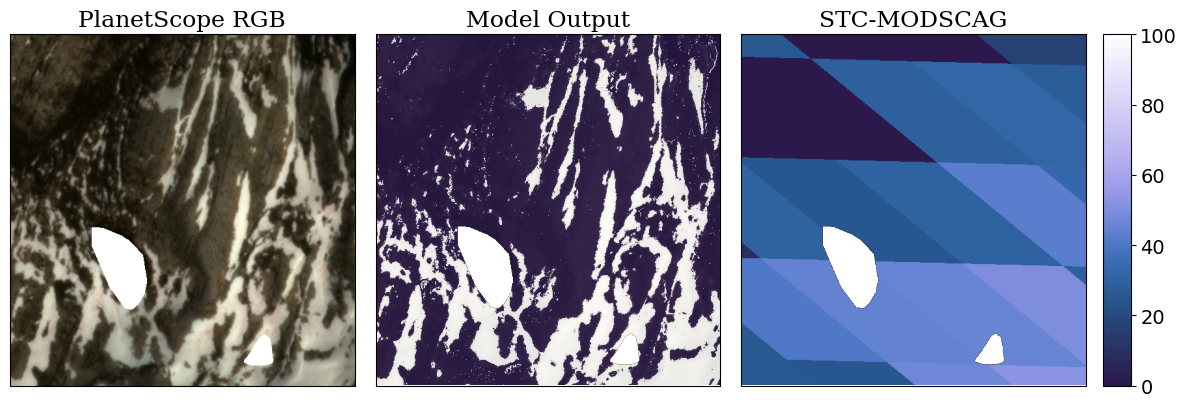

In [93]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Ensure CRS of basin matches repo_modis_sca
basin = basin.to_crs(repo_modis_sca.rio.crs)
rgi_mask = gpd.read_file(rgi).to_crs(repo_modis_sca.rio.crs)
wbd_mask = gpd.read_file(wbd).to_crs(repo_modis_sca.rio.crs)
date = '2023-07-25'
fig, ax = plt.subplots(1,3, figsize=(12, 8))  # Adjusted to 4 columns
plt.rcParams['font.size'] = 14
csfont = {'fontname':'serif'}
# Sort dates for consistent plotting

ps_raw = f'/data0/images/planet/emma/planet/{name}/'

ps_raw_subdir =sorted([d for d in glob.glob(ps_raw + date.split('-')[0] + date.split('-')[1] + date.split('-')[2] + '*') if os.path.isdir(d)])[0]
raw_files = glob.glob(ps_raw_subdir+'/*/PSScene/*SR_clip.tif')[0]

raw = rxr.open_rasterio(raw_files, masked=True).rio.clip(basin.geometry).rio.clip(basin.geometry.values, basin.crs).rio.clip(rgi_mask.geometry.values, rgi_mask.crs, invert = True).rio.clip(wbd_mask.geometry.values, wbd_mask.crs, invert= True)
_,_,_,_,rgb_image = calc_rgb(raw)
p = xr.open_dataset(f'/data0/images/planet/emma/planet/rerun/{name}/PP/{name}_{model}_{year}_model_output.nc')
ax[0].imshow(rgb_image)
p_slice = p.sel(time=date).to_array().values[0, :, :]
p_slice = np.where(p_slice==2, np.nan, p_slice)
p_slice = np.where(p_slice==1, 100, p_slice)
modscag_slice = repo_modis_sca.sel(time=date).rio.clip(basin.geometry.values, basin.crs).rio.clip(rgi_mask.geometry.values, rgi_mask.crs, invert = True).rio.clip(wbd_mask.geometry.values, wbd_mask.crs, invert= True)
ax[0].imshow(rgb_image)
ax[1].imshow(rgb_image)
ax[1].imshow(p_slice, cmap = cmc.devon,vmin = 0,vmax = 100,alpha = .8)
ax[2].imshow(modscag_slice, cmap = cmc.devon,vmin = 0,vmax = 100)
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlim(140,670)
    a.set_ylim(1540,1000)
ax[0].set_title('PlanetScope RGB', fontname='serif')
ax[1].set_title('Model Output', fontname='serif')
ax[2].set_title('STC-MODSCAG', fontname='serif')
cax = ax[2].inset_axes((1.05, 0, 0.08, 1.0))
im = ax[2].imshow(modscag_slice, cmap=cmc.devon, vmin=0, vmax=100)
cbar =fig.colorbar(im, cax=cax, orientation='vertical')
# Force the colorbar to reflect the *original* data meaning
# cbar.set_ticks([0, 20, 40, 60, 80])
# cbar.set_ticklabels(['0', '20', '40', '60', '100']) 
plt.tight_layout()

In [ ]:
# use this to figure out how many pixels are in each kernel size based on radius

def create_circular_kernel(radius):
    """Create a circular kernel of specified radius."""
    size = 2 * radius + 1
    kernel = np.zeros((size, size), dtype=np.float32)
    center = radius

    for x in range(size):
        for y in range(size):
            if np.sqrt((x - center) ** 2 + (y - center) ** 2) <= radius:
                kernel[x, y] = 1
    pixels = kernel.size
    return kernel, pixels
kernel, pixels = create_circular_kernel(3)
radi = [1,2,3,4]

thres = [.25,.35,.45,.5,.55,.65,.75]
# save kernel size pizel count and area to dataframe
kernel_data = []

for i in radi:
    kernel, count = create_circular_kernel(i)
    for j in thres:
        pixels = np.sum(kernel == 1)
        area= pixels*9
        thresh_pixels = int(pixels * j)
        thresh_area = thresh_pixels * 9
        kernel_data.append({
            'radius': i,
            'threshold': j,
            'pixels': pixels,
            'thresh_pixels': thresh_pixels,
            'area': area,
            'thresh_area': thresh_area,
        })

# Convert to DataFrame
kernel_df = pd.DataFrame(kernel_data)
print(kernel_df)
        

    radius  threshold  pixels  thresh_pixels  area  thresh_area
0        1       0.25       5              1    45            9
1        1       0.35       5              1    45            9
2        1       0.45       5              2    45           18
3        1       0.50       5              2    45           18
4        1       0.55       5              2    45           18
5        1       0.65       5              3    45           27
6        1       0.75       5              3    45           27
7        2       0.25      13              3   117           27
8        2       0.35      13              4   117           36
9        2       0.45      13              5   117           45
10       2       0.50      13              6   117           54
11       2       0.55      13              7   117           63
12       2       0.65      13              8   117           72
13       2       0.75      13              9   117           81
14       3       0.25      29           